In [3]:
#! /usr/bin/env python
directories = ['early_release', 'released','clouds']

# Each directory contains an image directory with contains
# *.npy file containing the timestamps in an array
# and .png images 
# a resized_images directory with resized images

# Create a manifest that is a json object with the following structure
# {
#   "[directory_name]": {
#     "image_directory": "[directory_name]/images",
#     "resized_image_directory": "[directory_name]/resized_images",
#     "timestamps": [timestamp1, timestamp2, ...],
#     "image_filenames": [filename1, filename2, ...]
#   },
#   ....
# }

import json
import os
import numpy as np
from glob import glob
from typing import Dict, List
from typing import Dict, List, Union
from datetime import datetime, timezone, timedelta


In [2]:


def time_to_fname(time: int, suffix = '') -> str:
    dt = datetime.fromtimestamp(time/1000, timezone.utc)
    format = '%Y-%m-%dT%Hh%Mm'
    time_str = dt.strftime(format)
    return f'tempo_{time_str}{suffix}.png'


def fname_to_time(fname: str) -> int:
    time_str = fname.replace('tempo_', '').replace('.png', '')
    dt = datetime.strptime(time_str, '%Y-%m-%dT%Hh%Mm')
    return int(dt.timestamp() * 1000)

from typing import Mapping, TypedDict, Union, List, cast

class DirectoryInfo(TypedDict):
    image_directory: str
    resized_image_directory: str
    timestamps: List[int]

DirectoryStructure = Mapping[str, DirectoryInfo]
# {image_directory: str, resized_image_directory: str, timestamps: List[int]}
manifest: DirectoryStructure = {}


In [5]:
timedelta(minutes=5).total_seconds()

300.0

In [ ]:
def times_are_close(t1: int, t2: int, dt: int = 60) -> bool:
    return abs(t1 - t2) < dt

def int_to_datetime(t: int) -> datetime:
    return datetime.fromtimestamp(t/1000, timezone.utc)

In [ ]:

for directory in directories:
    print(directory)
    manifest[directory] = cast(DirectoryInfo, {})
    manifest[directory]['image_directory'] = os.path.join(directory, 'images')
    manifest[directory]['resized_image_directory'] = os.path.join(directory,'images', 'resized_images')
    timestamp_files =  glob(os.path.join(directory, 'images', 'times*.npy'))
    timestamps: List[int] = []
    for timestamp_file in timestamp_files:
        with open(timestamp_file, 'r') as f:
            ts = f.read()[1:-1].split(',')
            timestamps.extend(int(t) for t in ts)
    manifest[directory]['timestamps'] = timestamps
    # manifest[directory]['image_filenames'] = list(map(os.path.basename,glob(os.path.join(directory, 'images', 'tempo*.png'))))
    image_filenames = list(map(os.path.basename,glob(os.path.join(directory, 'images', 'tempo*.png'))))
    
    # Check if all timestamps have corresponding images
    test_ts = set([time_to_fname(t) for t in timestamps])
    test_fn = set(image_filenames)
    if test_ts != test_fn:
        print(f"Missing images for {directory}:\n {test_ts - test_fn}")
        print(f"Extra images for {directory}:\n {test_ts - test_fn}")
    else:
        print("\t All images present")
        print("\t Number of images: ", len(image_filenames))
    
    # sort the timestamps and filenames by timestamp
    manifest[directory]['timestamps'] = sorted(set(manifest[directory]['timestamps']))
    # manifest[directory]['image_filenames'] = sorted(manifest[directory]['image_filenames'], key=fname_to_time)

# check that the released and cloud timestampes are the same
# released_ts = set(manifest['released']['timestamps'])
# cloud_ts = set(manifest['clouds']['timestamps'])
# if released_ts == cloud_ts:
#     print("Released and cloud timestamps are the same")
# else:
#     print("Released and cloud timestamps are different")
#     print("Released - Cloud: ", [time_to_fname(s) for s in released_ts - cloud_ts])
#     print("Cloud - Released: ", [time_to_fname(s) for s in cloud_ts - released_ts])


early_release
	 All images present
	 Number of images:  309
released
Missing images for released:
 set()
Extra images for released:
 set()
clouds
	 All images present
	 Number of images:  2365


In [10]:
import matplotlib.pyplot as plt

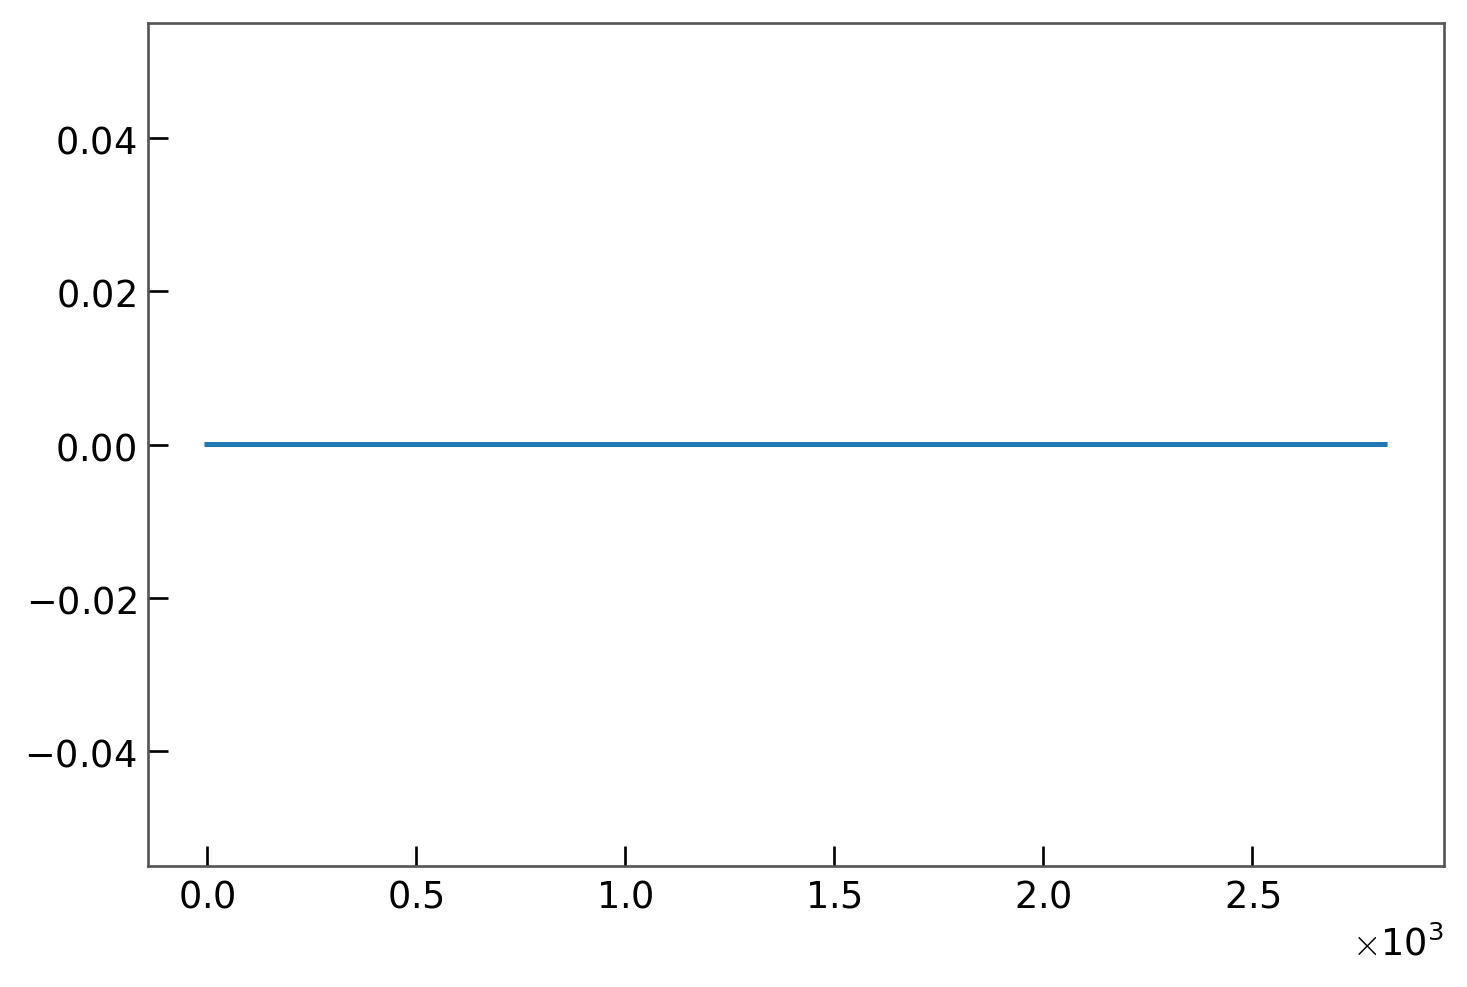

In [15]:
plt.plot(np.diff(sorted(set(manifest['released']['timestamps'])))==0)

In [ ]:

with open('manifest.json', 'w') as f:
    json.dump(manifest, f)


# run the ./format_json.sh manifest.json to format the json file
import subprocess
subprocess.run(['./format_json.sh', 'manifest.json'])

# # now we need to git add everything and commit and push
subprocess.run(['git', 'add', '.'])
timestamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
subprocess.run(['git', 'commit', '-m', f'Updated cloud data {timestamp}'])
subprocess.run(['git', 'push'])